In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [3]:
vec = torch.ones(1,3,5,6)
x = np.linspace(0, 1, vec.shape[2])
y = np.linspace(0, 1, vec.shape[2])
xx, yy = np.meshgrid(x, y)
print(xx)
data = torch.Tensor(np.dstack((xx, yy))).permute(2, 1, 0).unsqueeze(0)
print(data.shape)
print(torch.sin(data))

[[0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]]
torch.Size([1, 2, 5, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2474, 0.2474, 0.2474, 0.2474, 0.2474],
          [0.4794, 0.4794, 0.4794, 0.4794, 0.4794],
          [0.6816, 0.6816, 0.6816, 0.6816, 0.6816],
          [0.8415, 0.8415, 0.8415, 0.8415, 0.8415]],

         [[0.0000, 0.2474, 0.4794, 0.6816, 0.8415],
          [0.0000, 0.2474, 0.4794, 0.6816, 0.8415],
          [0.0000, 0.2474, 0.4794, 0.6816, 0.8415],
          [0.0000, 0.2474, 0.4794, 0.6816, 0.8415],
          [0.0000, 0.2474, 0.4794, 0.6816, 0.8415]]]])


100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


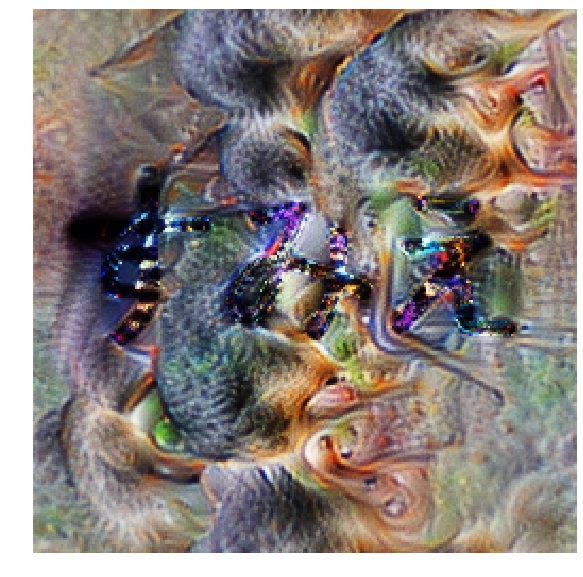

In [15]:
class Batch(torch.nn.Module):

    def __init__(self, n):
        super(Batch, self).__init__()
        self.n = n
        
    def forward(self, image):
        return torch.cat([image for _ in range(self.n)])
        

class ImageMask(torch.nn.Module):

    def __init__(self, mask):
        super(ImageMask, self).__init__()
        self.mask = mask
        
    def forward(self, image):
        
        return torch.cat((image[0,:,:,:]*(self.mask - 1),
                   image[1,:,:,:]*(self.mask)), dim=0)
        
class GradientMask(torch.nn.Module):

    def __init__(self, im):
        super(GradientMask, self).__init__()
        self.register_backward_hook(self.hook)
        self.register_buffer('mask', im)
        
    def forward(self, image):
        return image
    
    def hook(self, module, grad_input, grad_output):
        first = grad_input[0]
        second = grad_input[1]
        
        #x = np.linspace(0, 1, grad_input[0].shape[2])
        #y = np.linspace(0, 1, grad_input[0].shape[3])
        #xx, yy = np.meshgrid(x, y)
        #data = torch.Tensor(np.dstack((xx, yy))).permute(2, 1, 0).unsqueeze(0).to('cuda')
        #for i in range(3):
            #x2 = (data[0,0,:,:]-0.5) ** 2
            #y2 = (data[0,1,:,:]-0.5) ** 2
            #mask = torch.exp(-1*(x2/0.1+y2/0.1))
        first[0,:,:,:] = grad_input[0][0,:,:,:]*(1-self.mask)
        second[0,:,:,:] = grad_input[1][0,:,:,:]*(self.mask)
        return (first, second)
        #return (first,)

device = 'cuda'        
im = sumie.Image(256, param='fft', transforms=[
                    Batch(2),
                    ImageMask(sumie.io.load_file('mask.bmp', size=(256,256)).to(device)),
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.PositionJitter(16),
                    #sumie.transforms.RotationJitter(0.3),
                    #sumie.transforms.PositionJitter(16),
                    sumie.transforms.Interpolate(0.5),
                    sumie.transforms.Normalise(),
              ])

im.to(device)
model.to(device)
#channel = sumie.objectives.ConvChannel(model.features[26], 0, func=torch.mean)
obj1 = sumie.objectives.ConvChannel(model.features[26], 100, batch=0)
obj2 = sumie.objectives.ConvChannel(model.features[26], 5, batch=1)
combined = sumie.objectives.Composite([obj1, obj2], [10, 1])
opt = sumie.Optimiser(im, model.features, combined)

#opt.add_callback(change_combined)

opt.run(iterations=100, progress=True, lr=0.05)
sumie.vis.show(im.get_image(), figsize=(10,10))

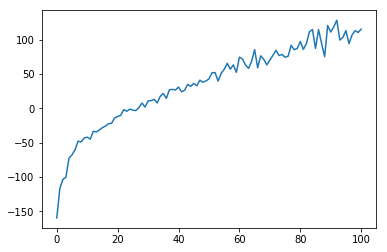

In [16]:
plt.plot([x.item() for x in opt.history])

In [17]:
for child in opt.objective.children:
    print(child.objective)


tensor(2.2747, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(92.4268, device='cuda:0', grad_fn=<MeanBackward1>)


In [7]:
print(im().shape)

torch.Size([2, 3, 254, 254])


In [8]:
t = torch.cat((torch.rand(0,3,5,5, requires_grad=True), torch.rand(0,3,5,5, requires_grad=True)))
print(t.grad_fn)